## 1. Importar librerías

En esta sección se importan las librerías principales para el análisis:

- `pandas`: manejo de datos en forma de tabla.
- `openpyxl`: motor para leer archivos de Excel `.xlsx`.

In [ ]:
import pandas as pd
import openpyxl

## 2. Cargar una muestra del archivo Excel y revisar estructura

Se carga la primera hoja del archivo Excel, limitando a 1000 filas para que el proceso sea más rápido.  
Se indica que ciertos valores (`"#NULL!"`, cadenas vacías) se traten como valores perdidos (NA).

Se revisa:
- Dimensiones del DataFrame (`shape`).
- Primeras filas (`head`).
- Estructura y tipos de datos (`info`).

In [7]:
df = pd.read_excel(
    "KMC-70k-93-2024-Malnutricion-conVel-DATA-SPSS-20250322.xlsx",
    sheet_name=0,
    nrows=1000,                # <-- solo lee las primeras 1000 filas
    na_values=["#NULL!", "", " "]
)

df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 753 entries, Idenfinal to velocidad6_3mesesOMS
dtypes: float64(610), int64(142), object(1)
memory usage: 5.7+ MB


### 3. Convertir comas decimales a punto

Varias columnas de z-score y otras vienen como texto con coma decimal (ej. -0,844856). Vamos a detectar y convertir:

In [8]:
# Columnas tipo texto que parecen tener decimales con coma
cols_coma = [
    c for c in df.columns
    if df[c].dtype == "object" and df[c].astype(str).str.contains(",", na=False).any()
]

for c in cols_coma:
    df[c] = df[c].astype(str).str.replace(",", ".", regex=False)
    df[c] = pd.to_numeric(df[c], errors="coerce")

### 4. Verificar estructura tras convertir comas decimales

Se revisa nuevamente la información del DataFrame (`info`) para confirmar que las columnas con coma decimal
se han convertido correctamente a tipo numérico (`float64`).

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 753 entries, Idenfinal to velocidad6_3mesesOMS
dtypes: float64(610), int64(142), object(1)
memory usage: 5.7+ MB


### 5. Resumen inicial de variables numéricas

Se seleccionan las columnas numéricas (`float64`, `int64`) y se genera un resumen estadístico:

- `count`: número de valores no nulos.
- `mean`, `std`: media y desviación estándar.
- `min`, `max`: valor mínimo y máximo.
- `25%`, `50%`, `75%`: cuartiles.

Esto ayuda a identificar rangos, posibles valores extremos y distribución general.

In [10]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Idenfinal,1000.0,1.000501e+06,289.090546,1.000001e+06,1.000252e+06,1.000502e+06,1.000751e+06,1.001001e+06
Iden_Codigo,1000.0,5.013060e+02,289.090546,1.000000e+00,2.517500e+02,5.015000e+02,7.512500e+02,1.001000e+03
Iden_Sede,1000.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
periodosanalisis,1000.0,2.512000e+00,0.500106,2.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
Sistemadeaseguramiento,1000.0,1.824000e+00,0.871656,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00
...,...,...,...,...,...,...,...,...
velocidadzscorepeso40_3m,500.0,9.178472e-01,0.900244,-1.529769e+00,3.378842e-01,8.552895e-01,1.509730e+00,3.534322e+00
velocidadzscore3m_40semOMS,500.0,1.312643e-01,0.903428,-2.329231e+00,-4.518960e-01,7.400000e-02,6.979858e-01,2.847943e+00
velocidad12_9mesesOMS,376.0,1.271367e-01,0.397090,-2.692795e+00,-1.132333e-01,1.071870e-01,3.339072e-01,1.556417e+00
velocidad9_6mesesOMS,423.0,1.436323e-01,0.468588,-1.156190e+00,-1.335770e-01,1.209580e-01,3.957160e-01,3.059353e+00


### 6. Resumen de variables categóricas

Se identifican las variables de tipo `object` o `category` y, para cada una, se muestran las
10 categorías más frecuentes (`value_counts`). Esto permite ver:

- Codificación de las variables (por ejemplo 0/1, 1/2/3).
- Presencia de valores ausentes (`NaN`).
- Distribución de respuestas en variables clave.

In [11]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns

for c in cat_cols:
    print("Variable:", c)
    print(df[c].value_counts(dropna=False).head(10))
    print("-" * 40)

Variable: V227
V227
NaN    999
S        1
Name: count, dtype: int64
----------------------------------------


### 7. Valores perdidos

Se calcula, para cada columna:
- `n_na`: número de valores faltantes.
- `pct_na`: porcentaje de valores faltantes sobre el total de filas.

Se listan las 30 variables con mayor proporción de NA. Esto orienta sobre:

- Variables poco completas (quizás no útiles para análisis).
- Posibles problemas de carga de datos o secciones no diligenciadas.

In [12]:
na_counts = df.isna().sum().sort_values(ascending=False)
na_percent = (na_counts / len(df)) * 100
missing = pd.concat([na_counts, na_percent], axis=1)
missing.columns = ["n_na", "pct_na"]

missing.head(30)

,n_na,pct_na
CSP_TipoVivienda,1000,100.0
Iden_FechaParto,1000,100.0
CSP_NutricionFam,1000,100.0
CSP_Menores5vivenMadre,1000,100.0
CSP_numPersVivenIngMen,1000,100.0
CSP_IngresoMensual,1000,100.0
edaddestete,1000,100.0
CSP_AyudaPerm1mes,1000,100.0
CSP_MesTabajoEmba,1000,100.0
CP_HospitalizacionEmbarazoInfeccionUrinaria,1000,100.0


### 8. Estado nutricional al nacimiento vs 12 meses (tablas cruzadas)

Se explora la relación entre las categorías de z-score al nacimiento y a los 12 meses:

- `zscorepeso0cat` vs `zscorepeso12cat`
- `zscoretalla0cat` vs `zscoretalla12cat`

Las tablas de contingencia (`crosstab`) permiten ver cuántos niños se mantienen, mejoran o empeoran
en su categoría nutricional a lo largo del seguimiento.

In [13]:
# Tabla de categorías de z-score de peso
pd.crosstab(df["zscorepeso0cat"], df["zscorepeso12cat"], margins=True)
pd.crosstab(df["zscoretalla0cat"], df["zscoretalla12cat"], margins=True)

zscoretalla12cat,1.0,2.0,All
zscoretalla0cat,,,
1.0,29,10,39
2.0,99,235,334
3.0,1,2,3
All,129,247,376


### 9. Cambios en z-score entre nacimiento y 12 meses

Se crean dos nuevas variables:

- `delta_zpeso_0_12`: diferencia entre z-score de peso a 12m y al nacer.
- `delta_ztalla_0_12`: diferencia entre z-score de talla a 12m y al nacer.

Luego se describe su distribución (`describe`), lo que ayuda a entender si en promedio hay
mejoría, empeoramiento o estabilidad en peso y talla.

In [14]:
df["delta_zpeso_0_12"] = df["zscorepeso12"] - df["zscorepeso0"]
df["delta_ztalla_0_12"] = df["zscoretalla12"] - df["zscoretalla0"]

df[["delta_zpeso_0_12", "delta_ztalla_0_12"]].describe()

,delta_zpeso_0_12,delta_ztalla_0_12
count,414.000000,376.000000
mean,0.042114,-1.066166
std,1.262029,1.434492
min,-5.342024,-6.184167
25%,-0.636914,-1.953375
50%,0.069910,-1.091495
75%,0.871449,-0.127072
max,4.339275,3.377295


### 10. Lactancia vs. nutrición a 12 meses

Se explora la asociación entre alimentación/lactancia y estado nutricional:

- `ali3m` vs `zscorepeso12cat`: tipo de alimentación a 3 meses y categoría de peso a 12m.
- `LME40` vs `zscorepeso12cat`: lactancia materna exclusiva a 40 semanas vs peso a 12m.
- `algoLM3meses` vs `indexnutricion12meses`: presencia de algo de leche materna a 3m
  y un índice nutricional global a 12m.

Se utilizan tablas cruzadas normalizadas por fila (`normalize="index"`) para interpretar proporciones.

In [16]:
# Tipo de alimentación a 3 meses vs estado nutricional a 12m
pd.crosstab(df["ali3m"], df["zscorepeso12cat"], normalize="index")

# Lactancia materna exclusiva a 40 semanas vs zscorepeso12cat
pd.crosstab(df["LME40"], df["zscorepeso12cat"], normalize="index")

# Algo de leche materna a 3 meses vs indexnutricion12meses
pd.crosstab(df["algoLM3meses"], df["indexnutricion12meses"], normalize="index")

indexnutricion12meses,0.0,1.0
algoLM3meses,,
0.0,0.333333,0.666667
1.0,0.242515,0.757485


### 11. Complicaciones neonatales vs. crecimiento

Se analizan dos ejemplos de complicaciones y su relación con el crecimiento a 12 meses:

- `ERN_sepsis` vs `zscoretalla12cat`: sepsis neonatal y categorías de talla a 12m.
- `HD_C_DisplasiaBronco` vs `zscorepeso12cat`: displasia broncopulmonar y categorías de peso a 12m.

Luego, se comparan estadísticas descriptivas del z-score de peso a 12m según presencia/ausencia
de estas complicaciones (`groupby` + `describe`).

In [18]:
# Sepsis neonatal vs talla a 12 meses
pd.crosstab(df["ERN_sepsis"], df["zscoretalla12cat"], normalize="index")

# Displasia broncopulmonar vs peso a 12 meses
pd.crosstab(df["HD_C_DisplasiaBronco"], df["zscorepeso12cat"], normalize="index")

zscorepeso12cat,1.0,2.0,3.0
HD_C_DisplasiaBronco,,,
0,0.138996,0.857143,0.003861
1,0.166667,0.833333,0.000000


In [19]:
df.groupby("ERN_sepsis")["zscorepeso12"].describe()
df.groupby("HD_C_DisplasiaBronco")["zscorepeso12"].describe()

,count,mean,std,min,25%,50%,75%,max
HD_C_DisplasiaBronco,,,,,,,,
0,259.0,-0.867435,1.096255,-4.663409,-1.526195,-0.880138,-0.240538,2.011612
1,156.0,-0.867682,1.204756,-4.771672,-1.656921,-0.768566,-0.042555,1.807949


### 12. Hospitalización vs. crecimiento (zscorepeso12)

Se explora la relación entre:

- `HD_TotalDiasHospital`: número total de días de hospitalización.
- `zscorepeso12`: z-score de peso a los 12 meses.

Se calcula la correlación y se visualiza la asociación con un diagrama de dispersión
(`scatterplot`), lo que puede indicar si estancias más prolongadas se asocian con
peor (o mejor) estado nutricional a 12m.

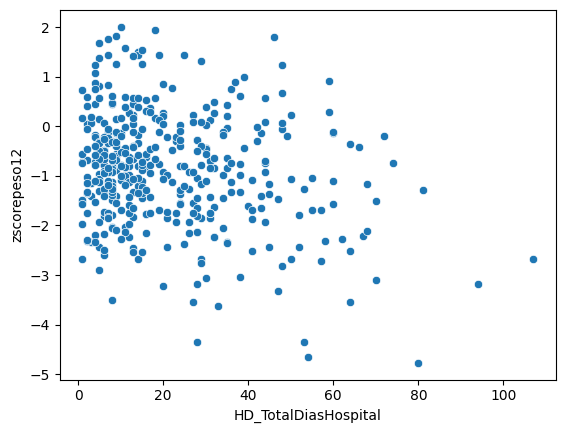

In [20]:
df[["HD_TotalDiasHospital", "zscorepeso12"]].corr()

import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x="HD_TotalDiasHospital", y="zscorepeso12", data=df)
plt.show()

### 13. Visualizaciones básicas

Se generan tres gráficos:

1. **Histograma de `zscorepeso0`**  
   Permite ver la distribución del z-score de peso al nacimiento, identificar si se
   centra en 0 (distribución normal) o desplazado hacia desnutrición/sobrepeso.

2. **Boxplot de `zscoretalla12` por `LME40`**  
   Compara la distribución de talla a 12m entre quienes tuvieron lactancia materna
   exclusiva a 40 semanas (`LME40`) y quienes no.

3. **Gráfico de barras de `zscorepeso12cat`**  
   Muestra el conteo de pacientes en cada categoría de z-score de peso a 12 meses.

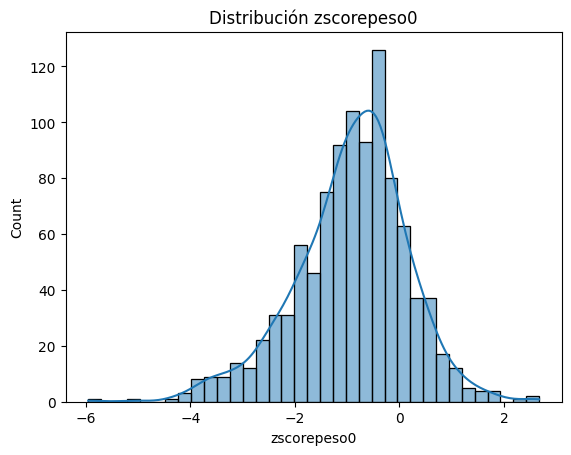

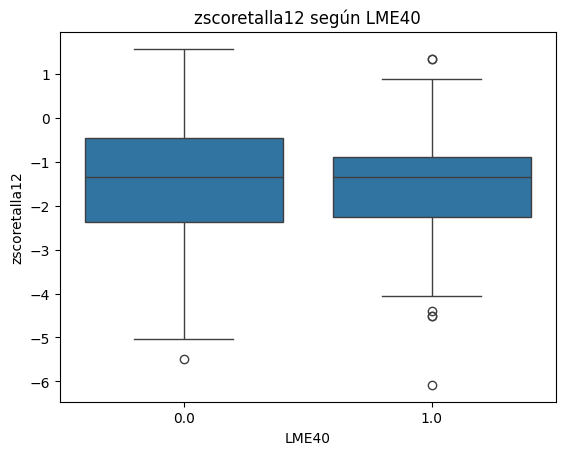

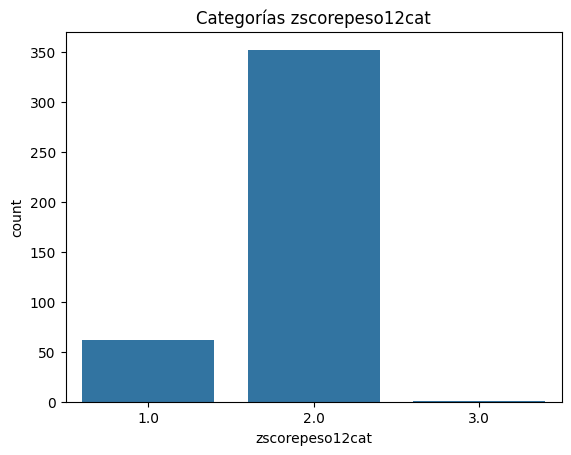

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma de zscorepeso0
sns.histplot(df["zscorepeso0"].dropna(), kde=True)
plt.title("Distribución zscorepeso0")
plt.show()

# Boxplot de zscoretalla12 por lactancia exclusiva a 40 semanas
sns.boxplot(x="LME40", y="zscoretalla12", data=df)
plt.title("zscoretalla12 según LME40")
plt.show()

# Barras: estado nutricional a 12m
sns.countplot(x="zscorepeso12cat", data=df)
plt.title("Categorías zscorepeso12cat")
plt.show()